In [37]:
import sys
sys.path.insert(0,'../')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from helpers import *
import os
import codecs
from collections import Counter
import pandas as pd
import seaborn as sns
import json
import urllib.parse
from urllib.request import urlopen
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np

## Load data

Each file in `DATA_DIR` should be a separate `.txt` file, representing a separate document. In our case, each file is a textbook.

In [4]:
DATA_DIR = "../data/coref_resolved_txts"

In [16]:
books = get_book_txts(DATA_DIR, splitlines=False)

Getting books...
America_A_Narrative_History_WWNorton_10th
America_Past_And_Present_Pearson_10th
Americas_History_Bedford_8th
Give_Me_Liberty_An_American_History_WWNorton_3rd
The_American_Pageant_Cengage_14th
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
american_history_connecting_with_the_past
by_the_people
history_alive_united_states_thru_industrialism
hmh_the_americans_us_history_since_1877
mastering_the_teks
pearson_us_history
teks_us_history
us_history_early_colonial_period_through_reconstruction
Finished getting books.


In [19]:
books['America_A_Narrative_History_WWNorton_10th'][:5000]

'History is filled with ironies. Luck and accidents—the unexpected and unplanned happenings of \xadlife—\u200b\xadoften shape events more than intentions. Long before Christopher Columbus lucked upon the Caribbean Sea and an unexpected continent in his effort to find a westward passage to the Indies (east Asia), the native peoples his mislabeled "Indians" had occupied and transformed the lands of the Western Hemisphere (also called the \xadAmericas—\u200b \xadNorth, Central, and South).\nInitially, everyone in what came to be called America came from somewhere else. By 1492, when Columbus began his voyage west from Spain across an uncharted ocean, there were millions of Native Americans living in the Western Hemisphere. The "New World" his found was new only to the Europeans who began exploring, conquering, and exploiting the region at the end of the fifteenth century. Over thousands of years, Native American peoples had developed highly sophisticated societies. Some were rooted in agr

# What topics occur in textbooks?

In [20]:
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import operator

**First, download and unzip the MALLET binary from `https://mallet.cs.umass.edu/download.php`**

In [21]:
NUM_TOPICS = 50
MALLET = "/Users/ddemszky/mallet-2.0.8/bin/mallet" # replace with your path
RANDOM_SEED = 42
output_dir = "../topics/gensim_" + str(NUM_TOPICS)
os.makedirs(output_dir, exist_ok=True)

### Functions for running the topic model and loading outputs

In [22]:
def get_topics(num, corpus, id2word, output_dir, all_sentences):
    """Run the topic model."""
    ldamallet = LdaMallet(MALLET,
                          corpus=corpus,
                          num_topics=num,
                          prefix=output_dir + "/",
                          workers=1,   # workers has to be 1, otherwise you get a java out of bounds exception
                          id2word=id2word,
                          iterations=1000,
                          random_seed=RANDOM_SEED,
                         alpha=5)
    keywords = {i: ",".join([word for word, prop in ldamallet.show_topic(i)]) for i in range(ldamallet.num_topics)}
    with open(output_dir + "/topic_names.json", 'w') as f:
        f.write(json.dumps(keywords))
    ldamallet.save(output_dir + "/model.mallet")
    ldamallet.show_topics(num_topics=num, formatted=True)
    return ldamallet

In [23]:
def eval_coherence(model, all_sentences, id2word):
    """Evaluate topic model coherence."""
    coherence_ldamallet = CoherenceModel(model=ldamallet,
                                               texts=all_sentences,
                                               dictionary=id2word,
                                               coherence='c_v')
    coherence_ldamallet = coherence_ldamallet.get_coherence()
    print('\nCoherence Score: ', coherence_ldamallet)
    return coherence_ldamallet

In [24]:
def get_topic_for_word(word, topic_names):
    """Show topics for a word / lemma."""
    topics = []
    for k, v in topic_names.items():
        if word in v:
            print(k, v)
            topics.append(int(k))
    return topics

In [25]:
def get_topic_for_words(words, topic_names):
    """Show topics for multiple words / lemmas."""
    topics = []
    for k, v in topic_names.items():
        if any([word in v.split(",") for word in words]):
            print(k, v)
            topics.append(int(k))
    return topics

In [26]:
def get_topic_for_doc(doc_id, printout=True):
    """Display topics for a given doc, given the doc id."""
    doc = all_sentences[doc_id]
    if printout:
        print(doc)
        #print(doc_topics[doc_id])
    topics = doc_topics[doc_id].strip().split()[2:]
    topics = set([i for (i, v) in enumerate(topics)
                         if float(v) > 0.1])
    if printout:
        print("Topics:")
        for t in topics:
            print(topic_names[str(t)])
    return len(topics)

# ----------------- STOP here: don't run cells below --------------------------------

The script below is to show you an example, but since it takes a long time to run, Dora will share the outputs with you. 

### Prepare data

Since chapter or paragraph length varies a lot by book, we treat each *sentence* as a document for the topic model. 

In [28]:
print("Cleaning and combining sentences across books...")
all_sentences = []
start_end = []
prev = 0
for title, book in books.items():
    print(title)
    sents = nltk.sent_tokenize(book)
    start = prev
    for i, s in enumerate(sents):
        if len(s) < 15:
            continue
        all_sentences.append(clean_text(s, stem=True, remove_short=True,
                                        stopwords_file="../wordlists/stopwords/en/mallet.txt"))
    end = start + len(sents) - 1
    start_end.append((title, start, end))
    prev = end + 1
    print("%d sentences" % len(sents))

Cleaning and combining sentences across books...
America_A_Narrative_History_WWNorton_10th
24210 sentences
America_Past_And_Present_Pearson_10th
26341 sentences
Americas_History_Bedford_8th
25921 sentences
Give_Me_Liberty_An_American_History_WWNorton_3rd
23108 sentences
The_American_Pageant_Cengage_14th
24419 sentences
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
17826 sentences
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
20938 sentences
american_history_connecting_with_the_past
24009 sentences
by_the_people
23383 sentences
history_alive_united_states_thru_industrialism
13229 sentences
hmh_the_americans_us_history_since_1877
23186 sentences
mastering_the_teks
5790 sentences
pearson_us_history
28846 sentences
teks_us_history
27129 sentences
us_history_early_colonial_period_through_reconstruction
15320 sentences


In [29]:
start_end_dict = {}
for tup in start_end:
    start_end_dict[tup[0]] = (tup[1], tup[2])
with open(output_dir + '/book_start_end.json', 'w') as f:
    f.write(json.dumps(start_end_dict))

In [30]:
print("%d sentences total" % len(all_sentences))

315212 sentences total


In [31]:
print("Creating the dictionary...")
id2word = corpora.Dictionary(all_sentences)
id2word.save(output_dir + '/dictionary.dict')

Creating the dictionary...


In [32]:
print("Getting term-document frequencies...")
corpus = [id2word.doc2bow(t) for t in all_sentences]

Getting term-document frequencies...


### Run topic model

In [33]:
print("Running topic model with %d topics..." % NUM_TOPICS)
ldamallet = get_topics(NUM_TOPICS, corpus, id2word, output_dir, all_sentences)

Running topic model with 50 topics...


Mallet LDA: 50 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 361
total tokens: 3500693
<10> LL/token: -10.16398
<20> LL/token: -9.09972
<30> LL/token: -8.76204
<40> LL/token: -8.62273

0	0.1	peopl imag great boy show time photograph pictur paint life light thing day depress suffer left make bodi depict shown 
1	0.1	govern power state feder nation peopl constitut protect author citizen control law local limit liberti individu unit establish system secur 
2	0.1	court suprem decis law school case rule justic marshal public feder constitut order chief segreg legal board separ educ action 
3	0.1	york governor william georg citi mari boston publish newspap call report henri promin made uncl tom irish sir cabin boss 
4	0.1	govern feder program administr deal secur public social econom provid bush nation act health aid reform fund reagan work system 
5	0.1	american british britain french franc coloni great colonist war revolut america independ indian empir english declar spa

<100> LL/token: -8.42292
<110> LL/token: -8.41469
<120> LL/token: -8.40589
<130> LL/token: -8.3991
<140> LL/token: -8.39189

0	0.1	imag photograph show boy day left cloth street symbol pictur burn cover tree light men made wall night back ground 
1	0.1	govern power feder nation constitut peopl citizen liberti freedom state protect individu author limit creat principl independ branch properti declar 
2	0.1	court suprem decis law school rule case justic state feder marshal constitut chief public legal educ segreg action judg order 
3	0.1	york citi smith william henri mari robert philadelphia polit governor john found promin reform boss uncl leader david tom politician 
4	0.1	govern feder program public social provid secur deal administr nation reform work fund health educ system creat aid agenc care 
5	0.1	british american britain french franc coloni great war colonist america revolut independ declar empir minist king north indian patriot alli 
6	0.1	peopl live time life person make chan

<200> LL/token: -8.36964
<210> LL/token: -8.36719
<220> LL/token: -8.36507
<230> LL/token: -8.36595
<240> LL/token: -8.36166

0	0.1	cloth fire water day left made hand burn gun tree hous ground wear street wall photograph air dress carri head 
1	0.1	govern power nation constitut feder freedom liberti peopl citizen protect individu state author properti declar principl creat limit independ branch 
2	0.1	court suprem decis law case justic rule school state constitut marshal chief feder public educ legal judg order scott segreg 
3	0.1	york william citi henri smith robert mari david john year found philadelphia polit charl uncl boston wrote boss tom leader 
4	0.1	govern feder program public provid social deal secur reform work nation administr educ system health creat fund care agenc establish 
5	0.1	british britain american french franc coloni war great colonist america independ revolut empir declar treati north patriot indian minist england 
6	0.1	peopl live make person life time good hu

<300> LL/token: -8.3554
<310> LL/token: -8.35449
<320> LL/token: -8.35409
<330> LL/token: -8.35362
<340> LL/token: -8.35263

0	0.1	cloth water fire hous long hand made gun men tree room dress red food wear ground feet hors cut burn 
1	0.1	govern power constitut nation freedom feder liberti citizen peopl protect individu state author principl independ properti declar creat law limit 
2	0.1	court suprem decis law rule justic case state school marshal chief feder constitut scott legal public judg action segreg equal 
3	0.1	york william henri john smith robert mari found david citi year wrote uncl publish tom born son leader charl journalist 
4	0.1	govern feder program public social deal provid educ reform secur work nation administr creat health system fund support establish care 
5	0.1	british britain american french coloni franc great colonist war independ revolut america empir declar treati north patriot king indian georg 
6	0.1	peopl live make time person life good human work thing ma

<400> LL/token: -8.35087
<410> LL/token: -8.35029
<420> LL/token: -8.35129
<430> LL/token: -8.35038
<440> LL/token: -8.34755

0	0.1	cloth water fire hous made hand hors food tree long gun dress red wear feet day cover burn bodi cut 
1	0.1	govern power nation constitut feder freedom liberti citizen peopl protect state individu author principl properti law declar independ creat limit 
2	0.1	court suprem decis law justic case rule state constitut feder chief marshal school scott legal public judg action segreg order 
3	0.1	william john york henri smith robert found mari son wrote david massachusett charl father year uncl brother publish famili journalist 
4	0.1	govern feder program public deal social provid work secur reform educ administr nation creat health fund system support care establish 
5	0.1	british britain american french coloni franc war great colonist independ revolut america declar empir patriot treati georg king north alli 
6	0.1	peopl live person make life good time human t

<500> LL/token: -8.34844
<510> LL/token: -8.34926
<520> LL/token: -8.34772
<530> LL/token: -8.34796
<540> LL/token: -8.34733

0	0.1	fire cloth water hand made hors hous long gun tree dress food burn men feet ground room head wear back 
1	0.1	govern power nation constitut feder peopl liberti freedom citizen protect state author individu principl declar properti independ creat limit law 
2	0.1	court suprem decis law case rule justic constitut state marshal feder chief scott legal school action judg segreg public equal 
3	0.1	john william henri york smith robert mari found son wrote david jame year father charl brother massachusett publish uncl tom 
4	0.1	govern feder program public deal social provid educ secur nation reform work administr system creat health fund care support establish 
5	0.1	british britain american french coloni franc colonist great war independ revolut america declar empir georg patriot king treati north loyalist 
6	0.1	peopl live person make good life human time thi

<600> LL/token: -8.34538
<610> LL/token: -8.34518
<620> LL/token: -8.34686
<630> LL/token: -8.34463
<640> LL/token: -8.34528

0	0.1	fire cloth water made hors hand hous long gun tree food men dress soldier red feet wear room day burn 
1	0.1	govern power nation constitut feder liberti freedom citizen peopl protect state author individu declar principl creat properti limit independ law 
2	0.1	court suprem decis law rule justic case state constitut feder marshal chief scott legal judg school action segreg issu power 
3	0.1	john william henri york smith mari son wrote jame robert david found father publish year brown charl uncl hous tom 
4	0.1	govern feder program public social deal provid secur reform nation work educ administr system creat health support fund care establish 
5	0.1	british american britain french coloni franc great colonist war independ revolut america declar georg patriot treati empir king north loyalist 
6	0.1	peopl live person time life make good human natur thing work

<700> LL/token: -8.34315
<710> LL/token: -8.34332
<720> LL/token: -8.34314
<730> LL/token: -8.34258
<740> LL/token: -8.34351

0	0.1	fire cloth water hand hors made hous long men gun soldier tree feet ground wear day dress back cut food 
1	0.1	govern power nation constitut feder freedom liberti peopl citizen protect state author individu declar principl independ properti creat free system 
2	0.1	court suprem law decis case justic rule state constitut marshal chief feder scott legal judg action school equal order segreg 
3	0.1	john william henri smith york son mari wrote robert found jame david publish father charl brown uncl journalist massachusett book 
4	0.1	govern feder program public deal social provid nation secur work reform system administr educ creat health fund establish care support 
5	0.1	british britain american french coloni franc colonist war great independ revolut america declar georg empir king patriot treati north minist 
6	0.1	peopl live person make life time good huma

<800> LL/token: -8.34292
<810> LL/token: -8.34141
<820> LL/token: -8.34258
<830> LL/token: -8.34195
<840> LL/token: -8.34206

0	0.1	water cloth fire made hors hand long ground men hous tree gun head feet soldier day burn wear dress food 
1	0.1	govern power nation constitut feder liberti freedom peopl citizen protect state individu author principl independ declar law properti creat free 
2	0.1	court suprem decis law case rule justic constitut state marshal feder chief scott legal judg action school equal power public 
3	0.1	john william henri smith york wrote mari son robert found brown jame david charl father publish massachusett uncl young book 
4	0.1	govern feder program public deal social provid secur nation reform system administr work educ creat health support fund establish care 
5	0.1	british britain american french coloni franc colonist great war revolut independ america declar georg empir patriot king treati north minist 
6	0.1	peopl live person make good life human time work 

<900> LL/token: -8.34202
<910> LL/token: -8.34195
<920> LL/token: -8.34058
<930> LL/token: -8.34172
<940> LL/token: -8.34163

0	0.1	water cloth fire hand made hors long hous tree soldier back gun head dress feet men wear day burn ground 
1	0.1	govern power nation constitut feder freedom peopl liberti citizen protect state author principl individu declar limit law independ properti branch 
2	0.1	court suprem decis law justic case rule state feder marshal constitut chief scott legal judg school action public equal segreg 
3	0.1	john william henri smith york wrote robert mari son brown jame david found publish charl massachusett year uncl father young 
4	0.1	govern feder program public deal social secur nation provid administr work educ system reform creat health fund care support establish 
5	0.1	british american britain french coloni franc war great colonist independ revolut america declar georg empir patriot king treati north minist 
6	0.1	peopl live person make time human good life na

<1000> LL/token: -8.34397

Total time: 5 minutes 45 seconds


In [34]:
#eval_coherence(ldamallet, all_sentences, id2word)

In [35]:
ldamallet.show_topics(num_topics=NUM_TOPICS, formatted=True)

[(0,
  '0.008*"water" + 0.008*"fire" + 0.008*"cloth" + 0.007*"hand" + 0.006*"hors" + 0.006*"made" + 0.005*"gun" + 0.005*"tree" + 0.005*"hous" + 0.005*"long"'),
 (1,
  '0.107*"govern" + 0.049*"power" + 0.030*"nation" + 0.027*"constitut" + 0.024*"feder" + 0.021*"liberti" + 0.020*"peopl" + 0.020*"freedom" + 0.018*"citizen" + 0.017*"protect"'),
 (2,
  '0.089*"court" + 0.050*"suprem" + 0.037*"law" + 0.036*"decis" + 0.027*"rule" + 0.026*"case" + 0.026*"justic" + 0.015*"state" + 0.013*"constitut" + 0.013*"marshal"'),
 (3,
  '0.034*"john" + 0.020*"william" + 0.017*"henri" + 0.013*"smith" + 0.012*"son" + 0.012*"wrote" + 0.011*"mari" + 0.010*"jame" + 0.010*"york" + 0.009*"robert"'),
 (4,
  '0.045*"govern" + 0.033*"feder" + 0.027*"program" + 0.021*"public" + 0.019*"deal" + 0.018*"social" + 0.016*"provid" + 0.016*"secur" + 0.016*"nation" + 0.014*"work"'),
 (5,
  '0.072*"british" + 0.050*"american" + 0.049*"britain" + 0.041*"french" + 0.036*"coloni" + 0.034*"franc" + 0.028*"great" + 0.028*"colonist

In [38]:
doc_topic_file =  output_dir+ '/doctopics.txt'
doc_topics = open(doc_topic_file).read().splitlines()
print(len(doc_topics), 'sentences total')

# Obtain doc topic matrix
doc_topic_mat = np.array([[float(n) for n in l.strip().split("\t")[2:]] for l in doc_topics])
print(doc_topic_mat.shape)

315212 sentences total
(315212, 50)


In [39]:
topic_names = json.load(open(output_dir + '/topic_names.json', 'r'))
topic_names

{'0': 'water,fire,cloth,hand,hors,made,gun,tree,hous,long',
 '1': 'govern,power,nation,constitut,feder,liberti,peopl,freedom,citizen,protect',
 '2': 'court,suprem,law,decis,rule,case,justic,state,constitut,marshal',
 '3': 'john,william,henri,smith,son,wrote,mari,jame,york,robert',
 '4': 'govern,feder,program,public,deal,social,provid,secur,nation,work',
 '5': 'british,american,britain,french,coloni,franc,great,colonist,war,independ',
 '6': 'peopl,live,person,make,good,natur,human,life,time,thing',
 '7': 'soviet,union,germani,war,europ,china,alli,german,hitler,japan',
 '8': 'roosevelt,wilson,presid,nation,franklin,peac,william,theodor,polici,taft',
 '9': 'church,religi,christian,protest,cathol,minist,religion,communiti,god,reform',
 '10': 'west,river,railroad,mississippi,land,great,region,california,gold,mountain',
 '11': 'immigr,peopl,group,american,popul,number,chines,countri,larg,ethnic',
 '12': 'social,polit,societi,american,class,progress,idea,cultur,middl,econom',
 '13': 'citi,yor

In [40]:
get_topic_for_doc(9)

['societi', 'european', 'nativ', 'merican', 'collid', 'nativ', 'distinct', 'heritag', 'worldview', 'indian', 'peopl', 'exploit', 'infect', 'enslav', 'displac', 'extermin']
Topics:
american,african,white,black,nativ,equal,racial,societi,enslav,live
indian,land,nativ,american,tribe,white,settler,west,cheroke,peopl
america,european,north,trade,spanish,africa,coloni,europ,empir,west


3

In [42]:
get_topic_for_word("wom", topic_names)

23 man,countri,day,woman,wrote,friend,hand,men,time,make
37 women,men,children,famili,work,woman,young,class,home,husband


[23, 37]

In [43]:
get_topic_for_words(["slave","black", "slaveri"], topic_names)

28 slave,south,black,white,southern,carolina,free,north,planter,slaveri
32 american,african,white,black,nativ,equal,racial,societi,enslav,live
34 school,black,student,white,civil,king,protest,colleg,movement,univers
41 slaveri,lincoln,southern,state,union,slave,free,south,northern,compromis


[28, 32, 34, 41]

In [44]:
get_topic_for_words(["women", "woman"], topic_names)

23 man,countri,day,woman,wrote,friend,hand,men,time,make
37 women,men,children,famili,work,woman,young,class,home,husband


[23, 37]

In [45]:
get_topic_for_words(["men", "man"], topic_names)

23 man,countri,day,woman,wrote,friend,hand,men,time,make
37 women,men,children,famili,work,woman,young,class,home,husband


[23, 37]

## What are prominent topics?

### Prominence as measured by averaging the topic matrix

In [118]:
for t in doc_topic_mat.mean(axis=0).argsort()[::-1]:
    print("%.3f %s" % (doc_topic_mat.mean(axis=0)[t], topic_names[str(t)]))

0.023 armi, forc, battl, general, union, british, troop, confeder, soldier, command
0.022 american, social, societi, cultur, polit, freedom, idea, econom, life, tradit
0.021 elect, vote, democrat, republican, parti, presid, won, candid, presidenti, elector
0.021 day, hand, fire, man, night, back, crowd, shot, soldier, men
0.021 peopl, liberti, declar, man, freedom, independ, men, natur, common, countri
0.021 state, constitut, amend, congress, law, vote, convent, pass, govern, act
0.021 america, north, european, coloni, spanish, trade, empir, africa, spain, explor
0.021 industri, busi, good, compani, railroad, trade, market, product, manufactur, oil
0.021 coloni, british, england, colonist, english, king, act, massachusett, virginia, parliament
0.021 tax, money, bank, govern, pay, debt, feder, billion, loan, nation
0.021 govern, power, nation, feder, state, peopl, constitut, system, believ, control
0.021 war, world, civil, american, end, cold, fight, america, militari, conflict
0.021 wa

### Prominence by counting most prominent topic for each document

In [137]:
topic_counts = np.zeros(NUM_TOPICS)
for i in range(NUM_TOPICS):
    topic_counts[i] = (doc_topic_mat[:, i] > 0.1).sum()
topic_counts

array([12623., 14632., 15801., 13729., 14471., 15007., 12428., 16986.,
       17116., 14151., 14452., 16941., 14869., 13938., 15881., 13741.,
       13959., 12648., 15428., 14336., 15333., 13200., 15027., 15920.,
       14569., 14952., 14557., 14509., 14619., 14416., 17427., 15156.,
       15745., 16748., 15003., 15325., 14407., 17005., 15512., 14334.,
       13632., 13005., 14266., 11882., 13286., 16088., 14050., 15709.,
       14049., 15522.])

In [139]:
for t in topic_counts.argsort()[::-1]:
    print("%d %s" % (topic_counts[t], topic_names[str(t)]))

17427 american, social, societi, cultur, polit, freedom, idea, econom, life, tradit
17116 armi, forc, battl, general, union, british, troop, confeder, soldier, command
17005 state, unit, nation, war, world, power, britain, countri, america, independ
16986 war, world, civil, american, end, cold, fight, america, militari, conflict
16941 peopl, liberti, declar, man, freedom, independ, men, natur, common, countri
16748 day, hand, fire, man, night, back, crowd, shot, soldier, men
16088 face, problem, american, nation, challeng, remain, danger, made, difficult, prove
15920 slave, black, white, south, african, slaveri, southern, free, american, freedom
15881 govern, power, nation, feder, state, peopl, constitut, system, believ, control
15801 women, men, famili, children, work, class, home, young, middl, mother
15745 coloni, british, england, colonist, english, king, act, massachusett, virginia, parliament
15709 presid, roosevelt, polici, foreign, nation, wilson, administr, nixon, kennedi, rea

## How do topic proportions differ across books, based on the political affiliation of their readership?

**For plotting**

In [147]:
shape_mapper = get_shapes(abbr=True)
color_mapper = get_colors(abbr=True)
title_abbr = get_title_abbr()

def get_ratio_of_topic_prominence(topic1, topic2, name1, name2):
    df_ratio = []
    df_book = []
    df_dem = []
    for i, t in enumerate(books):
        # remove books that only cover half of US history
        if 'early' in t or 'industr' in t or 'since' in t:
            continue
        df_book.append(title_abbr[t])
        df_dem.append(dem_per_book[t])
        df_ratio.append(book_means[i][topic1] / book_means[i][topic2])
    return pd.DataFrame({'Book': df_book, 'ratio': df_ratio, 'dem': df_dem})

In [156]:
def plot_on_axis(df, ax, title, x="dem", y="ratio", show_legend=False, fontsize=12, show_ylabel=True,
                p_value_show=0.05, p_val_pos=.6):
    p = sns.scatterplot(x, # Horizontal axis
       y, # Vertical axis
       data=df, # Data source
       hue='Book',
       style='Book',
       markers=shape_mapper,
       palette=color_mapper,
       s=100, ax=ax, legend=show_legend)
    
    # Fit a line
    slope, intercept, r_value, p_value, std_err = linregress(df[x], df[y])
    print(r_value)
    print(p_value)
    ax.plot(df[x], intercept + slope*df[x], 'grey', label='_nolegend_')
    
    ax.axhline(y=1, color='b', label='Equal Topic Frequency', linestyle='--')
    ax.text(x=23, y=p_val_pos,s="$\it{r}$ = %.2f\n$\it{p}$ %s" % (r_value, p_value_show))
    ax.set_title(title, fontsize=fontsize+4)
    if show_ylabel:
        ax.set_ylabel('Ratio of Topic Prominence', fontsize=fontsize)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Median % of Democrats Across Counties\nWhere Book is Bought', fontsize=fontsize)
    ax.set_ylim(df[y].min()-.1, df[y].max()+.1)
    sns.despine()

In [148]:
with open('../data/dem_per_book.json', 'r') as f:
    dem_per_book = json.load(f)

In [155]:
book_means = []
for title in books:
    start, end = start_end_dict[title]
    doc_topics_book = doc_topics[start:end]
    book_means.append(np.array([[float(n) for n in l.strip().split("\t")[2:]] for l in doc_topics_book]).mean(axis=0))

In [204]:
get_topic_for_words(["slaveri", "slave"])

23 slave,black,white,south,african,slaveri,southern,free,american,freedom
29 slaveri,south,state,lincoln,southern,union,compromis,free,north,territori


[23, 29]

In [206]:
get_topic_for_words(["militari", "armi"])

7 war,world,civil,american,end,cold,fight,america,militari,conflict
8 armi,forc,battl,general,union,british,troop,confeder,soldier,command
44 soviet,union,war,american,communist,militari,forc,nuclear,iraq,china


[7, 8, 44]

In [207]:
name1 = "Slavery"
name2 = "Military"
slavery_df = get_ratio_of_topic_prominence(23, 8, # Find topic ids above
                                           name1, name2)
slavery_df

,Book,ratio,dem
0,"Am. Narr. Hist., W.W.N.",0.783686,23.115068
1,"Am. Past & Present, Pearson",1.086372,44.776642
2,"Am. Hist., Bedford",1.140012,41.628411
3,"Give Me Liberty, W.W.N.",1.345837,45.465251
4,"The Am. Pageant, Cengage",0.908966,37.182643
5,"The Unfinished Nation, M.H.",0.988210,45.465251
6,"Visions of Am., Pearson",0.831802,23.506769
7,"Am. Hist. Conn. w/ Past, M.H.",0.954573,42.969170
8,"By The People, Pearson",0.847578,35.309294
9,"Mastering the TEKS, Jarret",0.963049,25.177986


0.7810371791542343
0.0027081310705319435


<Figure size 432x288 with 0 Axes>

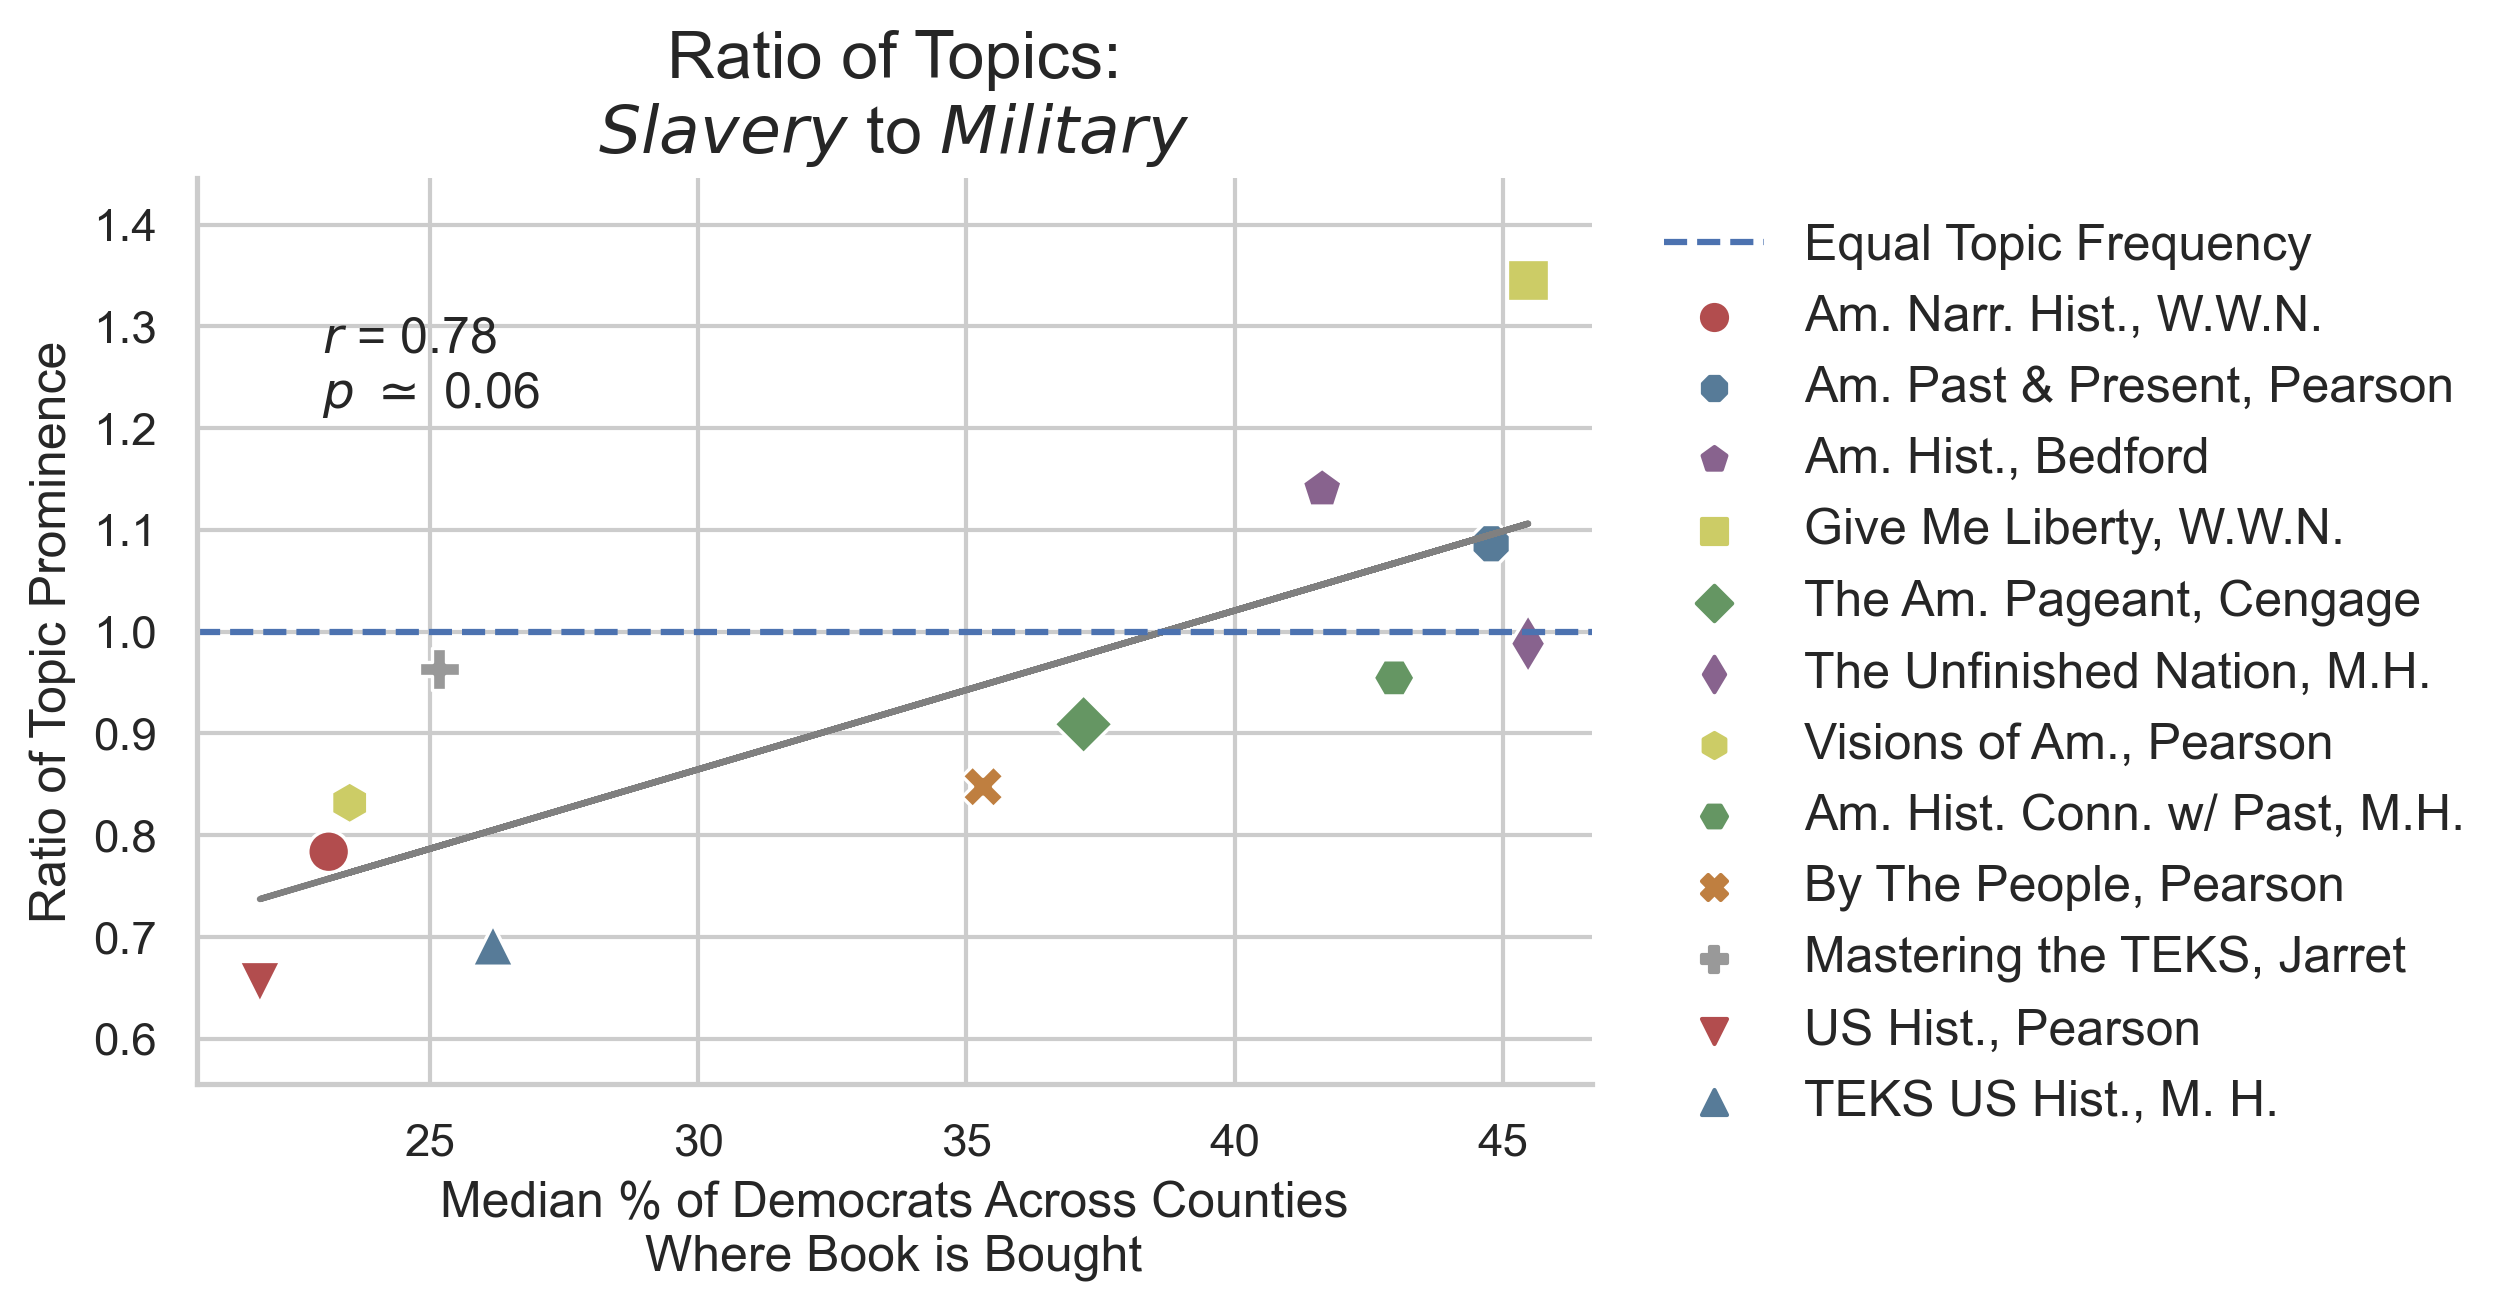

In [208]:
sns.set(style='whitegrid')
sns.despine()
fontsize=12
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(111)
title1 = "Ratio of Topics:\n$\it{"+name1 + "}$ to $\it{"+name2+"}$"
plot_on_axis(slavery_df, ax1, title1, fontsize=fontsize, show_ylabel=True, show_legend="full", 
             p_value_show="$\simeq$ 0.06", p_val_pos=1.22)
l = plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", frameon=False, fontsize=fontsize)
#l.texts[1].set_text('')

# ------------- Exercise: Run topic model for one book only -----------------

## `America_A_Narrative_History_WWNorton_10th`

In [224]:
NUM_TOPICS = 50
TITLE = "America_A_Narrative_History_WWNorton_10th"

output_dir_book = "../topics/gensim_" + str(NUM_TOPICS) + "/" + TITLE
os.makedirs(output_dir_book, exist_ok=True)

### Prepare data for book

In [ ]:
# Create a list of sentences

In [ ]:
# Create a dictionary

In [ ]:
# Get term-document frequencies

### Run topic model

In [ ]:
# Run topic model

In [ ]:
# Display topics

In [ ]:
# Load doc-topic file

In [ ]:
# Load topic words

### Obtain topic prominence

In [227]:
# Count the most prominent topic in each document

# --------------------------------- BELOW IF TIME ------------------------------------

# How are groups and individuals described?

In [41]:
from gensim.models import phrases, word2vec, Word2Vec, KeyedVectors
import nltk
from nltk.corpus import stopwords
from itertools import chain
import numpy as np
from scipy.stats import ttest_ind
from adjustText import adjust_text

In [47]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/ddemszky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ddemszky/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Word embeddings (word2vec)

See this great Medium blog post for a tutorial on word2vec embeddings: https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1

### Prepare data

In [23]:
books = get_book_txts("../data/source_txts", splitlines=False)  # use original (unprocessed texts)

Getting books...
America_A_Narrative_History_WWNorton_10th
America_Past_And_Present_Pearson_10th
Americas_History_Bedford_8th
Give_Me_Liberty_An_American_History_WWNorton_3rd
The_American_Pageant_Cengage_14th
The_Unfinished_Nation_A_Concise_History_of_the_American_People_McGraw-Hill_8th
Visions_of_America_A_History_of_the_United_States_Pearson_2nd
american_history_connecting_with_the_past
by_the_people
history_alive_united_states_thru_industrialism
hmh_the_americans_us_history_since_1877
mastering_the_teks
pearson_us_history
teks_us_history
us_history_early_colonial_period_through_reconstruction
Finished getting books.


In [48]:
stop = set(stopwords.words('english'))

In [49]:
def get_sentences(book):
    sents = nltk.sent_tokenize(book)
    return [clean_text(s, stem=False, remove_stopwords=False, remove_short=False) for s in sents]

In [50]:
print("Getting sentences...")
all_sentences = []
for title, book in books.items():
    all_sentences.extend(get_sentences(book))

Getting sentences...


In [51]:
all_sentences[:10]

[['america',
  'a',
  'not',
  'so',
  'new',
  'world',
  'pa',
  'r',
  't',
  'one',
  'history',
  'is',
  'filled',
  'with',
  'ironies'],
 ['luck',
  'and',
  'accidents',
  'the',
  'unexpected',
  'and',
  'unplanned',
  'happenings',
  'of',
  'life',
  'often',
  'shape',
  'events',
  'more',
  'than',
  'intentions'],
 ['long',
  'before',
  'christopher',
  'columbus',
  'lucked',
  'upon',
  'the',
  'caribbean',
  'sea',
  'and',
  'an',
  'unexpected',
  'continent',
  'in',
  'his',
  'effort',
  'to',
  'find',
  'a',
  'westward',
  'passage',
  'to',
  'the',
  'indies',
  'east',
  'asia',
  'the',
  'native',
  'peoples',
  'he',
  'mislabeled',
  'indians',
  'had',
  'occupied',
  'and',
  'transformed',
  'the',
  'lands',
  'of',
  'the',
  'western',
  'hemisphere',
  'also',
  'called',
  'the',
  'americas',
  'north',
  'central',
  'and',
  'south'],
 ['initially',
  'everyone',
  'in',
  'what',
  'came',
  'to',
  'be',
  'called',
  'america',
  'came

In [52]:
# Create model
bigrams = phrases.Phrases(all_sentences, min_count=5, delimiter=b' ', common_terms=stop)

In [53]:
data = bigrams[all_sentences]

In [54]:
# Create vocabulary of bigrams
print("Creating vocabulary...")
vocab = [w for sent in data for w in sent]
vocab = [w for w, count in Counter(vocab).most_common() if count >= 5]
vocab = set(vocab)

Creating vocabulary...


In [55]:
vocab

{'tender',
 'clipper ship',
 'causing',
 'union membership',
 'extends',
 'pageants',
 'abolishes',
 'glasses',
 'far exceeded',
 'becoming',
 'proprietor',
 'tarred and feathered',
 'reflect the characteristics',
 'bellows',
 'minister neville',
 'twelfth',
 'elements',
 'dignified',
 'avail',
 'charms',
 'suggests',
 'recklessly',
 'couples',
 'earlier generations',
 'special field',
 'greenwich',
 'public housing',
 'gouverneur morris',
 'national ethos',
 'susquehanna',
 'party ticket',
 'stills',
 'northerners opposed',
 'shifting trend',
 'animals',
 'tribesmen',
 'economically and socially',
 'pelham',
 'confederation congress',
 'overview',
 'bundle',
 'regulated',
 'refused to accept',
 'read the section',
 'river valley',
 'analyzing causes',
 'blacksmiths',
 'oil shipments',
 'spangled banner',
 'tennessee and kentucky',
 'disapproving',
 'fair treatment',
 'la raza',
 'senator stephen',
 'protestors',
 'resurgence of the 1990s',
 '49th',
 'birney',
 'nordic',
 'braddock',
 

### Train model

In [32]:
data = bigrams[all_sentences]
model = word2vec.Word2Vec(data, size=300, window=5, sg=1, min_count=5, workers=10)http://localhost:8889/notebooks/tutorials/EDUC423B%20-%20Topic%20modeling%20in%20Python.ipynb#Train-model

In [69]:
#model.wv.save(os.path.join("../data/word2vec_models", 'word2vec_d300.wv'))

### Get closest words

In [56]:
model = KeyedVectors.load(os.path.join("../data/word2vec_models", 'word2vec_d300.wv'))

In [57]:
def get_closest(queries, models, vocab, idx2word):
    cosines = []
    for m in models:
        cosines.append([np.mean([m.similarity(q, word) for q in queries]) for word in vocab])
    cosines = np.mean(np.array(cosines), axis=0)
    return [(idx2word[idx], cosines[idx]) for idx in cosines.argsort()[-20:][::-1]]

In [58]:
def filter_words(words, vocab):
    words = set(words)
    not_in_vocab = words - vocab
    if not_in_vocab:
        print("Not in vocab:")
        print(not_in_vocab)
    return list(words - not_in_vocab)

In [59]:
queries = ["she", "her", "woman", "hers", "women"]

# Remove queries not in vocab
queries = filter_words(queries, set(vocab))
vocab = list(vocab)
idx2word = {i: w for i, w in enumerate(vocab)}

print("Getting most similar words...")
closest = get_closest(queries, [model], vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))

Getting most similar words...
woman 0.65
she 0.62
husband 0.62
her 0.61
herself 0.61
wife and mother 0.58
angelina 0.57
housewife 0.57
matoaka 0.57
biddy 0.57
mother 0.57
wheatley 0.56
grandmother 0.56
lucy 0.56
steinem 0.56
hers 0.56
eleanor 0.56
maid 0.56
sister 0.56
married woman 0.56


In [60]:
queries = ["he", "him", "his", "man", "men"]

# Remove queries not in vocab
queries = filter_words(queries, set(vocab))
vocab = list(vocab)
idx2word = {i: w for i, w in enumerate(vocab)}

print("Getting most similar words...")
closest = get_closest(queries, [model], vocab, idx2word)
for (w, c) in closest:
    print("%s %.2f" % (w, c))

Getting most similar words...
disgraced 0.50
he 0.49
him 0.48
kentuckian 0.48
man 0.48
bulldog 0.48
sassamon 0.48
holy spirit 0.47
wife martha 0.47
man whose 0.47
pointedly 0.47
his 0.47
abolitionist cause 0.47
scoundrel 0.47
carmichael 0.47
barnett 0.47
jesus christ 0.47
stare 0.47
catcher 0.47
appropriately 0.47


### Get proximity to queries

In [63]:
def get_cosines(name1, name2, words1, words2, queries, models):
    df_w1 = []
    df_w2 = []
    df_q = []
    df_type = []
    df_pvals = []
    for key, values in queries.items():
        for q in values:
            vals1 = [m.similarity(word1, q) for m in models for word1 in words1]
            vals2 = [m.similarity(word2, q) for m in models for word2 in words2]
            df_w1.append(np.mean(vals1))
            df_w2.append(np.mean(vals2))
            df_q.append(q)
            df_type.append(key)
            df_pvals.append(ttest_ind(vals1, vals2)[1])
    df = pd.DataFrame({name1: df_w1, name2: df_w2, 'query': df_q, 'word category': df_type, "p value": df_pvals})
    return df

In [64]:
queries = {
  "home": ["home", "domestic", "household", "chores", "family"],
  "work": ["work", "labor", "workers", "economy", "trade", "business",
           "jobs", "company", "industry", "pay", "working", "salary", "wage"],
  "achievement": ["power", "authority", "achievement", "control", "took control",
                  "won", "powerful", "success", "better", "efforts", "plan", "tried", "leader"],
}
words1 = ["she", "her", "hers", "woman", "women"]
words2 = ["he", "him", "his", "man", "men"]
words1 = filter_words(words1, set(vocab))
words2 = filter_words(words2, set(vocab))
for k, v in queries.items():
    queries[k] = filter_words(v, set(vocab))

In [65]:
print("Calculating similarity...")
sims = get_cosines("Women", "Men", words1, words2, queries, [model])
print(sims.head())

Calculating similarity...
      Women       Men      query word category   p value
0  0.383673  0.213130     family          home  0.004358
1  0.406981  0.296271     chores          home  0.072670
2  0.451867  0.223357  household          home  0.000409
3  0.266351  0.147508   domestic          home  0.018083
4  0.285501  0.201438       home          home  0.012522


In [66]:
sims.loc[sims["p value"] < 1, "significance"] = ""
sims.loc[sims["p value"] < 0.05, "significance"] = "0.05"
sims.loc[sims["p value"] < 0.01, "significance"] = "0.01"
sims.loc[sims["p value"] < 0.001, "significance"] = "0.001"
mapper = {"": "", "0.05": r"$^\bigodot$", "0.01": r"$^\nabla$", "0.001": r"$^\Psi$"}
sims["query"] = sims["query"] + sims["significance"].map(mapper)

In [67]:
def plot_cosines(df):
    plt.figure(figsize=(8, 8), dpi=300)
    sns.set(style='whitegrid')
    sns.despine()
    x = df.columns[1]
    y = df.columns[0]
    style = "word category"
    palette = sns.color_palette("Set1", n_colors=len(df[style].unique()), desat=.7)
    color_mapper = {"home": "#00755E", "work": "#00468C", "achievement": palette[0]}
    p1 = sns.scatterplot(x, # Horizontal axis
           y, # Vertical axis
           data=df, # Data source
           hue=style,
           style=style,
           legend='brief',
           palette= color_mapper,
           markers={"home": "s", "work": "D", "achievement": "o"},
           s=40,
    )  
    texts =[]
    for line in range(0,df.shape[0]):
        word = df['query'][line]
        cat = df[style][line]
        texts.append(plt.text(df[x][line], df[y][line], word, horizontalalignment='center', 
        size='x-small', color=color_mapper[cat]))
    

    plt.title('Cosine Similarities To...')
    lims = (0.05, .51)
    plt.xlim(lims[0], lims[1])
    plt.ylim(lims[0], lims[1])
    plt.plot(lims, lims, lw=.5, color="black")
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0))
    plt.text(.4, 0.1, "Significance:\n" + r"$\odot: p < 0.05$" + "\n" + r"$\nabla: p < 0.01$" + "\n" + r"$\Psi: p < 0.001$", {'color': 'black', 'fontsize': 12},
         horizontalalignment='left',
         verticalalignment='center',
         clip_on=False)

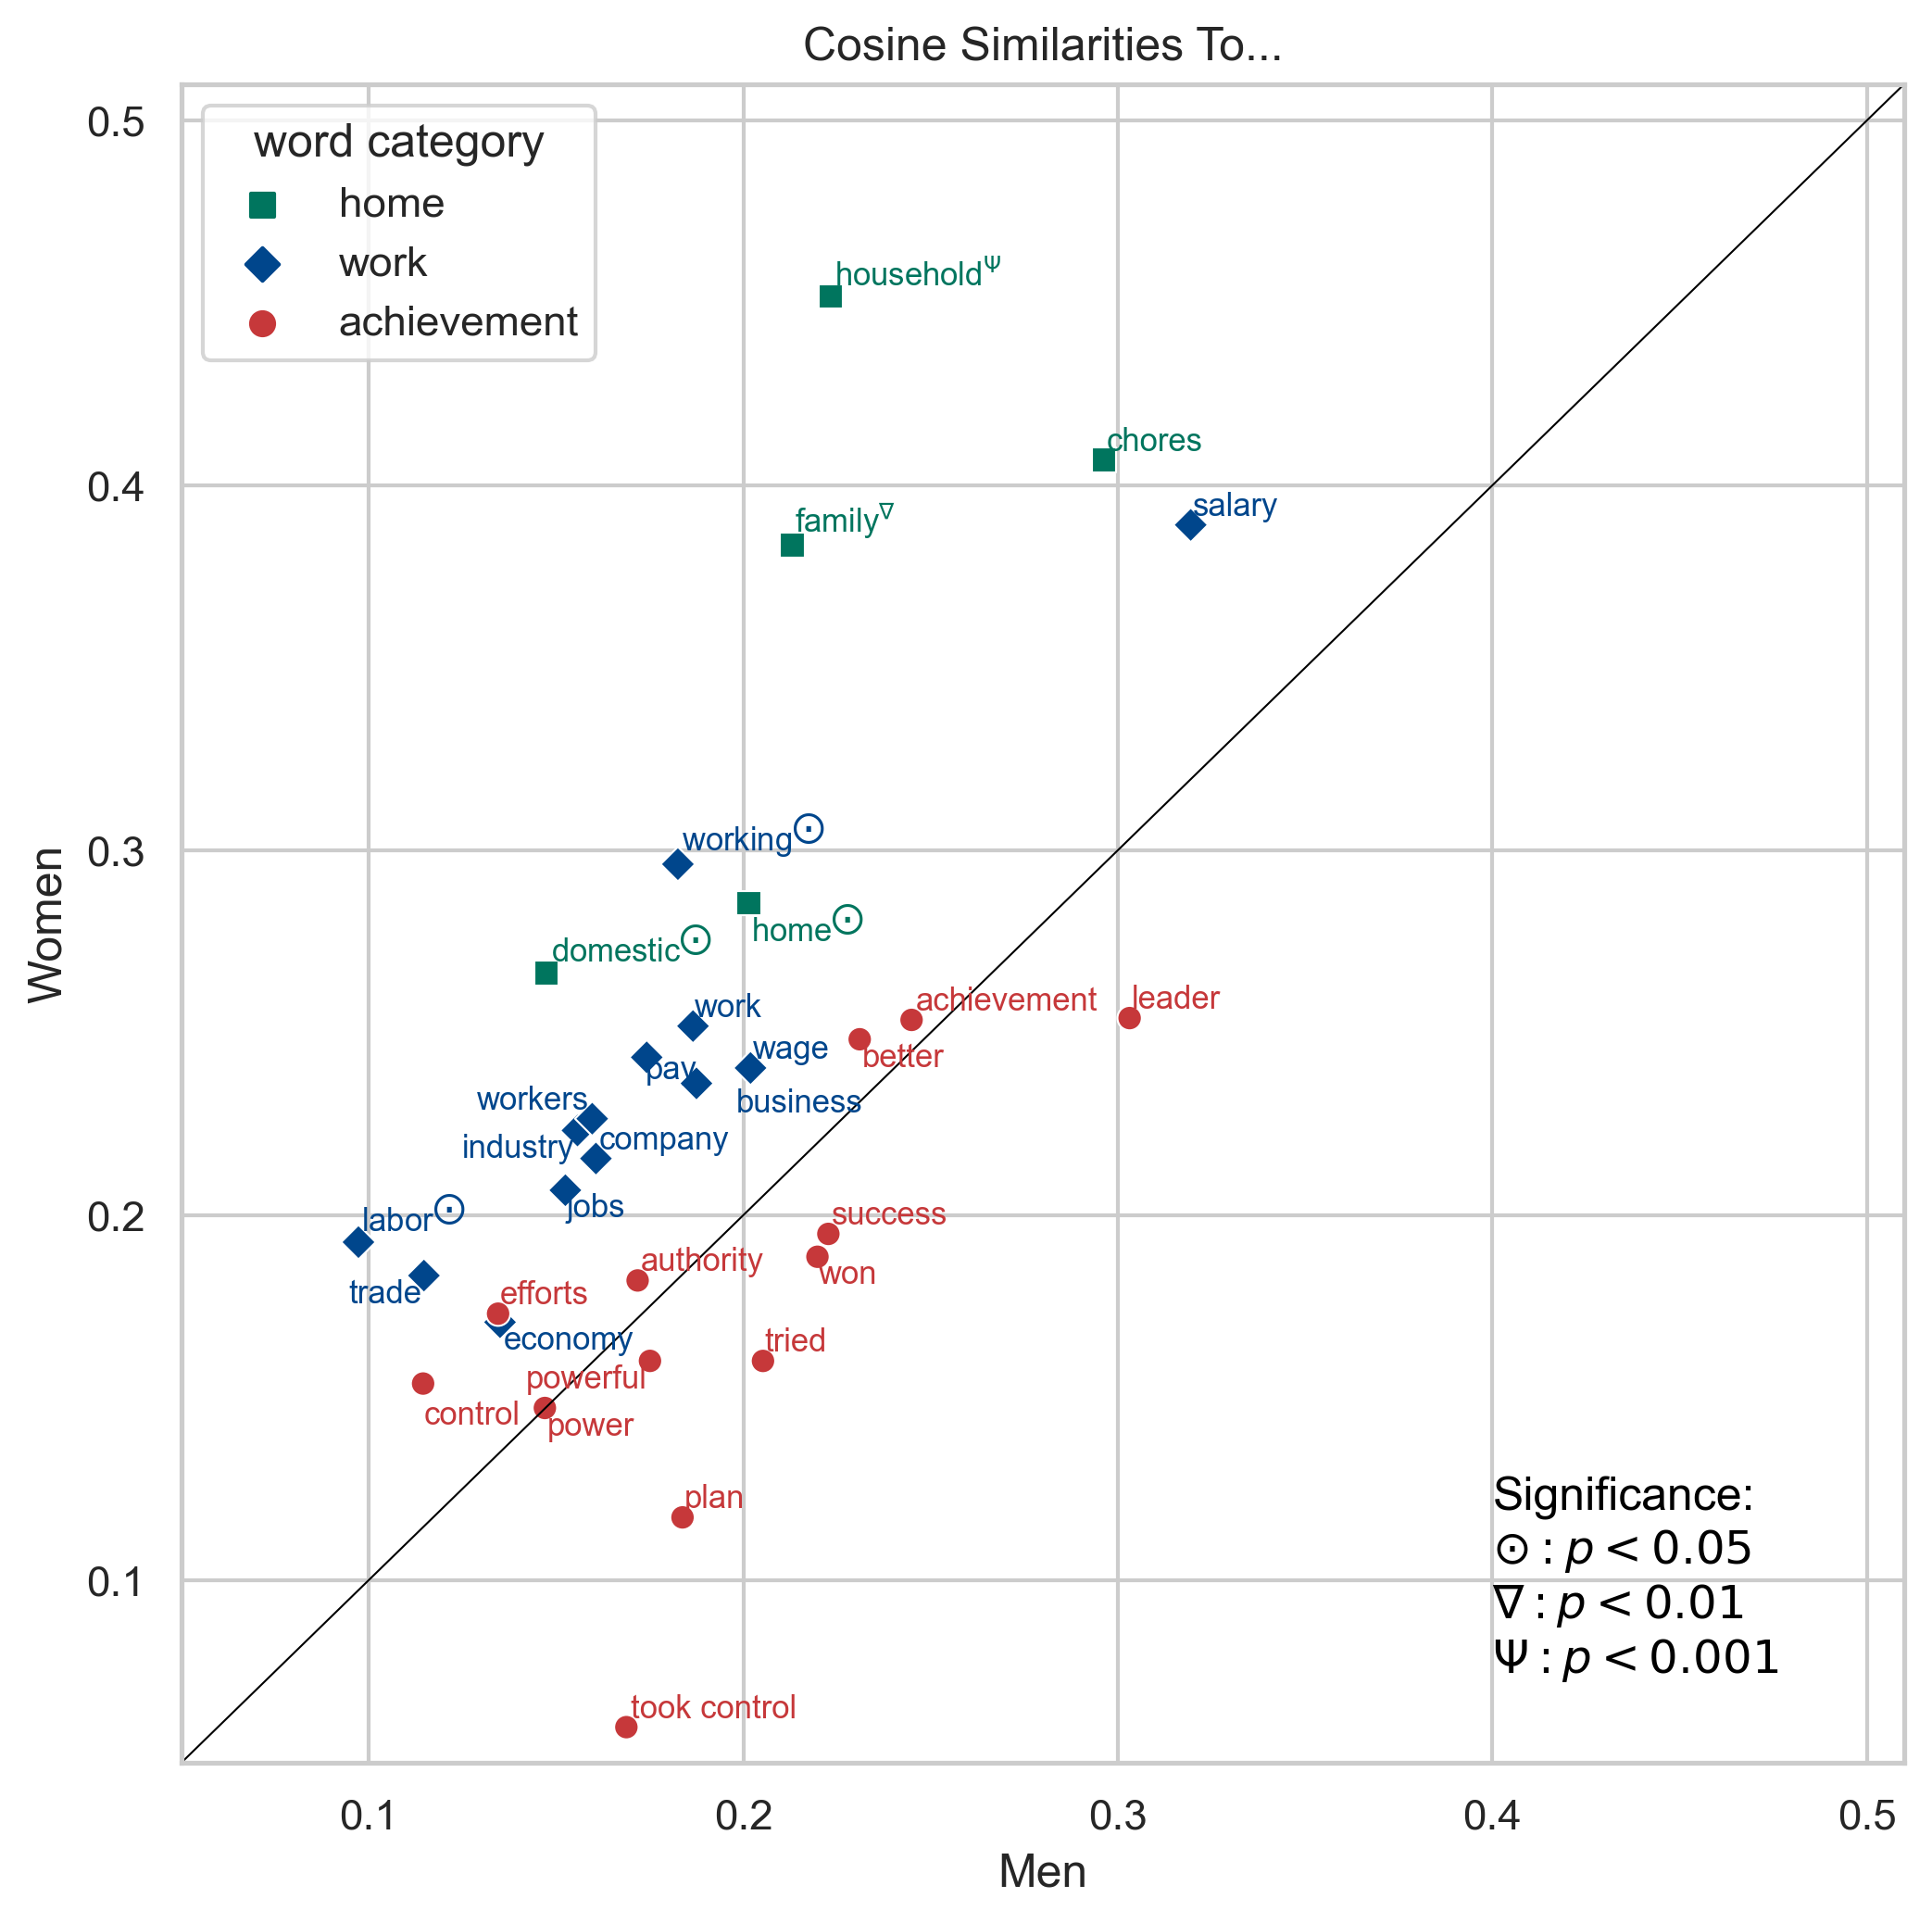

In [68]:
plot_cosines(sims)